# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
# https://github.com/tqdm/tqdm#manual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import torch.nn.functional as F
import re
from torch import nn, optim
from torchvision import transforms,datasets,models
from tqdm import tqdm 
from PIL import Image
from workspace_utils import active_session

In [2]:
# Selecting Device
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print("Device Running in: " + device_name)

Device Running in: cuda


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# https://pytorch.org/docs/0.3.0/torchvision/transforms.html

# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(45),
                transforms.RandomResizedCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #Comment this line to debug and see the pictures
    ])
    ,'test': transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #Comment this line to debug and see the pictures
    ])
}
# Defining Validation to be the same as test
data_transforms['valid'] = data_transforms['test']
data_transforms['train'] = data_transforms['test']



# data_transforms
print('Data Transforms Defined')

Data Transforms Defined


In [5]:
# data_transforms

In [6]:
# TODO: Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform = data_transforms['valid'])
image_datasets['test']  = datasets.ImageFolder(test_dir , transform = data_transforms['test'])

# image_datasets
print('Image Datasets Loaded')

Image Datasets Loaded


In [7]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader( image_datasets['train'], shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader( image_datasets['valid'], shuffle=True)
dataloaders['test']  = torch.utils.data.DataLoader( image_datasets['test'] , shuffle=True)

# dataloaders
print('Data Loaders Build')

Data Loaders Build


In [96]:
# # Printing the Dataloader Image. (remeber to remove normalization for this part)
# data_transforms_debug = {
#     'test': transforms.Compose([
#                 transforms.Resize(255),
#                 transforms.CenterCrop(224),
#                 transforms.ToTensor()
#                 #,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #Comment this line to debug and see the pictures
#     ])
# }

# image_datasets_debug = datasets.ImageFolder(test_dir , transform = data_transforms_debug['test'])

# for images, labels in image_datasets_debug:
#     #print(images)
#     print(labels)
#     #images
#     #plt.imshow(np.transpose(images[0].detach().cpu().numpy(), (1, 2, 0)))
#     #break

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
# Pick any string-number from 1 to 102 to get a name
# cat_to_name['102']
# cat_to_name['1']
cat_to_name['51']

'petunia'

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# TODO: Build and train your network

In [12]:
# loading a pre-trained Model
# This is to easily change between slections
# "Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)"

# model = models.resnet18(pretrained=True)
# model = models.alexnet(pretrained=True)
# model = models.squeezenet1_0(pretrained=True)
model = models.vgg16(pretrained=True)
# model = models.densenet161(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.shufflenet_v2_x1_0(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)
# model = models.resnext50_32x4d(pretrained=True)
# model = models.wide_resnet50_2(pretrained=True)
# model = models.mnasnet1_0(pretrained=True)

# importedModel
print('Model Imported')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:30<00:00, 18004338.76it/s]


Model Imported


In [13]:
# Using the convolution layer as it is. Keeping it from changing during training.
for param in model.parameters():
    param.requires_grad = False

print('Feature model imported frozen from learning')

Feature model imported frozen from learning


In [14]:
# model

In [15]:
# 'Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout'
dropout_rate = 0.2
input_layer = 25088 #Make the same as the output from the pre-trained model (features model)
flower_categories = 102 #The output of our model
learning_rate = 0.0001

# creating the model

model.classifier = nn.Sequential(
    nn.Linear(input_layer, 8000),
    nn.ReLU(),
    nn.Dropout( p = dropout_rate ),
    nn.Linear(8000, flower_categories),
    nn.LogSoftmax(dim=1)
)

# Selecting a loss criteria 
# https://pytorch.org/docs/stable/nn.html?highlight=criterion
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()

# Selecting a Optimizer
optimizer = optim.Adam( model.classifier.parameters(), lr = learning_rate )
# optimizer = optim.SGD( model.parameters(), lr = learning_rate , momentum=0.9)
# optimizer = optim.ASGD( model.parameters(), lr = learning_rate , lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
# optimizer = optim.Adagrad( model.parameters(), lr = learning_rate , lr_decay=0, weight_decay=0, initial_accumulator_value=0)

# Moving to device
model.to(device)

print('Model, criterion and optmizer created into ' + device_name)

Model, criterion and optmizer created into cuda


In [16]:
# model

In [17]:
# Training
# 'Train the classifier layers using backpropagation using the pre-trained network to get the features'
epochs = 3
losses = {}
acc = {}
losses['train'], losses['valid'] = [],[]
acc['train'], acc['valid'] = [],[]

# Keep the notebook awake.
with active_session():
    for e in range(epochs):

        # ----- Training -----
        print("Training epoch: {}/{}   please wait...".format(e+1, epochs))
        train_loss = 0
        train_accuracy = 0
        train_len = len(dataloaders['train'])
        for images, labels in dataloaders['train']:
            

            # Training step 
            images_d, labels_d = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model( images_d )
            loss = criterion(output, labels_d)
            loss.backward()
            
            #print('\n\n Debug \n\n')
            # for param in model.classifier.parameters():
               # print( param )
               # print(param.grad.data.sum())
               #  break
            
            optimizer.step()      
            train_loss += loss.item()

            # Measuring Accuracy   
            output_prob = torch.exp(output)
            top_p, top_class = output_prob.topk(1, dim=1)
            equals = top_class == labels_d.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor))


        # ------ Model Results -----
        print("Evaluating epoch: {}/{}   please wait...".format(e+1, epochs))
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        valid_len = len(dataloaders['valid'])
        for images, labels in dataloaders['valid']:

            # Measuring Validation Accuracy 
            images_d, labels_d = images.to(device), labels.to(device)
            output = model( images_d )
            loss = criterion(output, labels_d)
            valid_loss += loss.item()
            output_prob = torch.exp(output)
            top_p, top_class = output_prob.topk(1, dim=1)
            equals = top_class == labels_d.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))

        # ----- Saving Losses and Accuracy -----     
        losses['train'].append(train_loss/len(dataloaders['train']))
        losses['valid'].append(valid_loss/valid_len)
        acc['train'].append(train_accuracy/len(dataloaders['train']))
        acc['valid'].append(valid_accuracy/valid_len)

        print("Epoch: {}/{} |".format(e+1, epochs),
              "Train Loss: {:.3f}  | ".format(train_loss    /train_len),
              "Train Accu: {:.3f}  | ".format(train_accuracy/train_len),
              "Valid Loss: {:.3f}  | ".format(valid_loss    /valid_len),
              "Valid Accu: {:.3f}    ".format(valid_accuracy/valid_len))

        model.train()

print("Model Trained")  

Training epoch: 1/3   please wait...
Evaluating epoch: 1/3   please wait...
Epoch: 1/3 | Train Loss: 1.509  |  Train Accu: 0.642  |  Valid Loss: 0.607  |  Valid Accu: 0.841    
Training epoch: 2/3   please wait...
Evaluating epoch: 2/3   please wait...
Epoch: 2/3 | Train Loss: 0.291  |  Train Accu: 0.931  |  Valid Loss: 1.095  |  Valid Accu: 0.790    
Training epoch: 3/3   please wait...
Evaluating epoch: 3/3   please wait...
Epoch: 3/3 | Train Loss: 0.234  |  Train Accu: 0.955  |  Valid Loss: 1.410  |  Valid Accu: 0.831    
Model Trained


In [18]:
# "Track the loss and accuracy on the validation set to determine the best hyperparameters"

In [19]:
# I have used so many parameters, but I did not save everyone of them

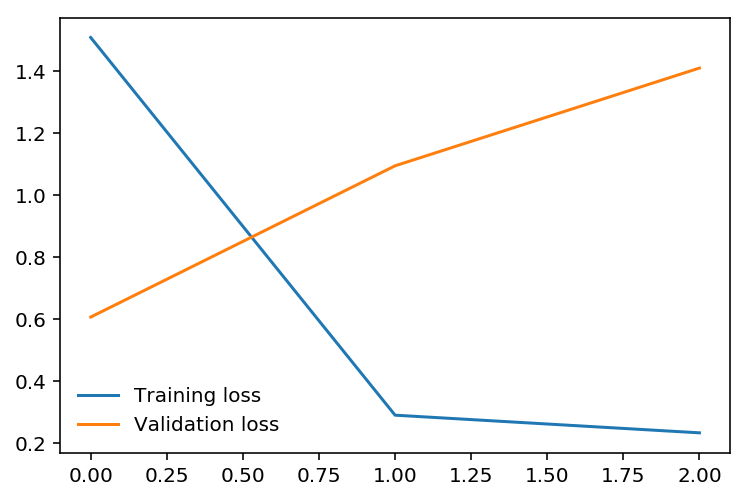

In [20]:
# Plotting the loses 
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['valid'], label='Validation loss')
plt.legend(frameon=False)

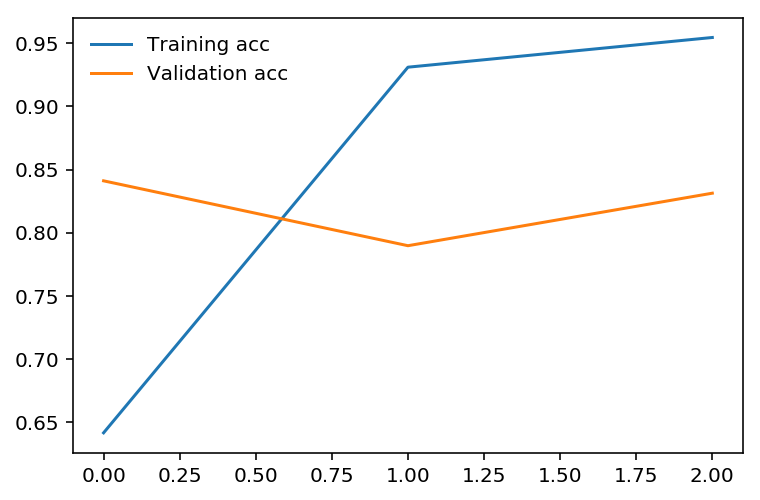

In [21]:
# Plotting the Accuracy 
plt.plot(acc['train'], label='Training acc')
plt.plot(acc['valid'], label='Validation acc')
plt.legend(frameon=False)

In [22]:
# Parameters 
# Imported: VGG
# Model
#     format: Input,500,Flower
#     Activation: Relu
#     Dropout: 0.2
# Optim: Adam
# Learn Rate: 0.01


# Training epoch: 1/5 
# Training epoch: 1/5  STEP: 6552/6552 
# Epoch: 1/5 | Train Loss: 4.918  |  Train Accuracy: 0.225  | Valid Loss: 4.614  |  Valid Accuracy: 0.024
# Training epoch: 2/5 
# Training epoch: 2/5  STEP: 13104/6552 
# Epoch: 2/5 | Train Loss: 4.598  |  Train Accuracy: 0.231  | Valid Loss: 4.514  |  Valid Accuracy: 0.034
# Training epoch: 3/5 
# Training epoch: 3/5  STEP: 19656/6552 
# Epoch: 3/5 | Train Loss: 4.572  |  Train Accuracy: 0.246  | Valid Loss: 4.510  |  Valid Accuracy: 0.034
# Training epoch: 4/5 

# Conclusion: The validation loss and accuracy is barely moving. Increasing LR AND adding a Layer.

In [23]:
# Parameters 
# Imported: VGG
# Model
#     format: Input,2000,500,Flower
#     Activation: Relu
#     Dropout: 0.2
# Optim: Adam
# Learn Rate: 0.1

# Training epoch: 1/5 
# Training epoch: 1/5  STEP: 6552/6552 
# Epoch: 1/5 | Train Loss: 173.982  |  Train Accuracy: 0.144  | Valid Loss: 4.724  |  Valid Accuracy: 0.034
# Training epoch: 2/5 
# Training epoch: 2/5  STEP: 13104/6552 
# Epoch: 2/5 | Train Loss: 19.390  |  Train Accuracy: 0.174  | Valid Loss: 4.696  |  Valid Accuracy: 0.034
# Training epoch: 3/5 
# Training epoch: 3/5  STEP: 19656/6552 
# Epoch: 3/5 | Train Loss: 62.595  |  Train Accuracy: 0.185  | Valid Loss: 4.779  |  Valid Accuracy: 0.018
# Training epoch: 4/5 
# Training epoch: 4/5  STEP: 26208/6552 
# Epoch: 4/5 | Train Loss: 55.837  |  Train Accuracy: 0.176  | Valid Loss: 4.686  |  Valid Accuracy: 0.017
# Training epoch: 5/5 
# Training epoch: 5/5  STEP: 32760/6552 
# Epoch: 5/5 | Train Loss: 179.327  |  Train Accuracy: 0.160  | Valid Loss: 4.675  |  Valid Accuracy: 0.034
# Model Trained

# Conclusion: It is instable, let get back to the reduced train

In [24]:
# Parameters 
# Imported: VGG
# Model
#     format: Input,2000,500,Flower
#     Activation: Relu
#     Dropout: 0.2
# Optim: Adam
# Learn Rate: 0.01




# Training epoch: 1/5   please wait...
# Evaluating epoch: 1/5   please wait...
# Epoch: 1/5 | Train Loss: 5.486  |  Train Accu: 0.031  |  Valid Loss: 4.520  |  Valid Accu: 0.026    
# Training epoch: 2/5   please wait...
# Evaluating epoch: 2/5   please wait...
# Epoch: 2/5 | Train Loss: 5.065  |  Train Accu: 0.027  |  Valid Loss: 4.514  |  Valid Accu: 0.026    
# Training epoch: 3/5   please wait...
# Evaluating epoch: 3/5   please wait...
# Epoch: 3/5 | Train Loss: 4.842  |  Train Accu: 0.028  |  Valid Loss: 4.520  |  Valid Accu: 0.034    
# Training epoch: 4/5   please wait...
# Evaluating epoch: 4/5   please wait...
# Epoch: 4/5 | Train Loss: 4.650  |  Train Accu: 0.032  |  Valid Loss: 4.504  |  Valid Accu: 0.026    
# Training epoch: 5/5   please wait...
# Evaluating epoch: 5/5   please wait...
# Epoch: 5/5 | Train Loss: 4.529  |  Train Accu: 0.031  |  Valid Loss: 4.508  |  Valid Accu: 0.031    
# Model Trained

# Conclusion: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [25]:
# TODO: Do validation on the test set
print('Testing the model')
model.eval()
for data_type in ['train','valid','test']:
    accuracy = 0
    
    
    data_size = len(dataloaders[data_type])
    for images, labels in dataloaders[data_type]:
        images, labels = images.to(device), labels.to(device)

        output = model( images )
       
        output_prob = torch.exp(output)
        top_p, top_class = output_prob.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    print("accuracy: {:.3f}  Type: {}   DataSize: {}".format(accuracy/data_size, data_type,data_size) )
model.train()

Testing the model
accuracy: 0.975  Type: train   DataSize: 6552
accuracy: 0.831  Type: valid   DataSize: 818
accuracy: 0.799  Type: test   DataSize: 819


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [26]:
file_name = 'renandias_model_checkpoint.pth'

In [27]:
# TODO: Save the checkpoint 
checkpoint = {
    'image_transform_train':data_transforms['train'],
    'image_transform_test_validation':data_transforms['test'],
    'class_to_index':image_datasets['train'].class_to_idx,
    'input_size': input_layer,
    'output_size': flower_categories,
    'optimizer_state_dict': optimizer.state_dict,
    'epochs':epochs,
    'model_state_dict': model.state_dict()
}


torch.save( checkpoint, file_name )
print('Checkpoitn Saved')

Checkpoitn Saved


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [28]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def restoremodel(state_dict):
    
    restored = models.vgg16(pretrained=True)
    restored.classifier = nn.Sequential(
            nn.Linear(input_layer, 8000),
            nn.ReLU(),
            nn.Dropout( p = dropout_rate ),
            nn.Linear(8000, flower_categories),
            nn.LogSoftmax(dim=1)
        )
    restored.load_state_dict( state_dict )
    
    return(restored)

print('Restoration Function Created')

Restoration Function Created


In [29]:
loaded_file = torch.load( file_name )

checkpoint_model = restoremodel(loaded_file['model_state_dict'])

print('Model Restored')

Model Restored


In [30]:
# checkpoint_model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

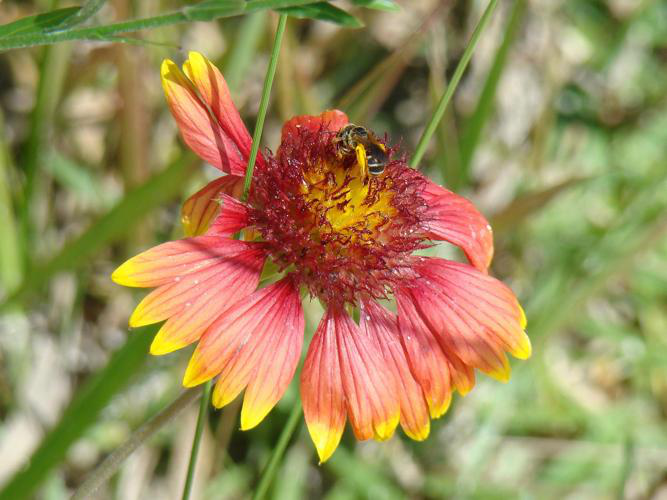

In [31]:
# Reading a image to plot
image_example_path = 'flowers/test/100/image_07902.jpg'
im = Image.open(image_example_path)
im

In [32]:
# Defining Values
resize = 256
cutsize = 224

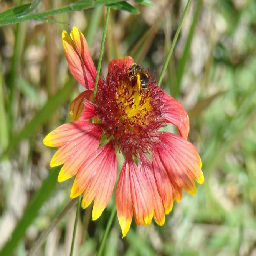

In [33]:
# Resisng
im_resized = im.resize((resize,resize))
im_resized

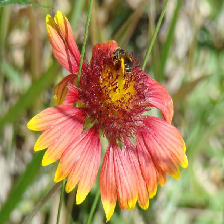

In [34]:
#Then you'll need to crop out the center 224x224 portion of the image.
margin = (resize-cutsize)/2
im_crop = im_resized.crop((margin, margin, resize-margin, resize-margin))
im_crop

In [35]:
#Convert from 0-255 to 0-1 
np_image = np.array(im_crop)/255
np_image

array([[[ 0.26666667,  0.45882353,  0.2745098 ],
        [ 0.25882353,  0.45882353,  0.29019608],
        [ 0.32941176,  0.48235294,  0.4627451 ],
        ..., 
        [ 0.32156863,  0.42745098,  0.16470588],
        [ 0.32156863,  0.44705882,  0.16078431],
        [ 0.37254902,  0.47058824,  0.24313725]],

       [[ 0.32941176,  0.51764706,  0.2745098 ],
        [ 0.4       ,  0.58431373,  0.36862745],
        [ 0.51764706,  0.69019608,  0.55294118],
        ..., 
        [ 0.32941176,  0.43529412,  0.16470588],
        [ 0.3372549 ,  0.4627451 ,  0.17647059],
        [ 0.40784314,  0.49803922,  0.27843137]],

       [[ 0.36078431,  0.53333333,  0.23137255],
        [ 0.34901961,  0.50980392,  0.23529412],
        [ 0.38431373,  0.58823529,  0.29803922],
        ..., 
        [ 0.33333333,  0.43921569,  0.16862745],
        [ 0.34901961,  0.4745098 ,  0.18823529],
        [ 0.43921569,  0.52941176,  0.30980392]],

       ..., 
       [[ 0.25490196,  0.42352941,  0.0627451 ],
        

In [36]:
#Normalize Mean and Standard Deviation
means = [0.485, 0.456, 0.406]
stddev = [0.229, 0.224, 0.225]

current_mean = np.mean(np_image,axis=(0,1))
print('Current Mean')
print(current_mean)

current_std = np.std(np_image,axis=(0,1))
print('Current std')
print(current_std)

Current Mean
[ 0.63916012  0.53118435  0.34928589]
Current std
[ 0.21493936  0.18915692  0.18598733]


In [37]:
# Normalize Mean and Standard Deviation Transformation

np_image_null_mean = np_image - current_mean
np_image_std_one = np_image_null_mean / current_std
np_image_std_transformed = np_image_std_one * stddev
np_image_transformed = np_image_std_transformed + means

In [38]:
# Cheking transformations
l = 15 #number to test the transformation
np_image.shape

(224, 224, 3)

In [39]:
np_image[l][l]

array([ 0.48627451,  0.42352941,  0.29019608])

In [40]:
np_image_null_mean[l][l]

array([-0.15288561, -0.10765494, -0.05908981])

In [41]:
np_image_std_one[l][l]

array([-0.71129648, -0.5691303 , -0.31770878])

In [42]:
np_image_std_transformed[l][l]

array([-0.16288689, -0.12748519, -0.07148448])

In [43]:
np_image_transformed[l][l]

array([ 0.32211311,  0.32851481,  0.33451552])

In [44]:
# Check after transformation
transformed_mean = np.mean(np_image_transformed,axis=(0,1))
print('Goal Mean and after the transformation')
print(means)
print(transformed_mean)

transformed_std = np.std(np_image_transformed,axis=(0,1))
print('Goal stddev and after the transformation')
print(stddev)
print(transformed_std)

Goal Mean and after the transformation
[0.485, 0.456, 0.406]
[ 0.485  0.456  0.406]
Goal stddev and after the transformation
[0.229, 0.224, 0.225]
[ 0.229  0.224  0.225]


In [45]:
# Reordering array
print('Starter Shape')
print(np_image_transformed.shape )

np_image_reorder = np_image_transformed.transpose((2,0,1))

print('Transformed Shape')
print(np_image_reorder.shape )

Starter Shape
(224, 224, 3)
Transformed Shape
(3, 224, 224)


In [46]:
# Defining Function

In [47]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''  
    means = [0.485, 0.456, 0.406]
    stddev = [0.229, 0.224, 0.225]
    resize = 256
    cutsize = 224
    
    #First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio.
    im_resized = image.resize((resize,resize))
    
    #Then you'll need to crop out the center 224x224 portion of the image.
    margin = (resize-cutsize)/2
    im_crop = im_resized.crop((margin, margin, resize-margin, resize-margin))
    
    #Convert from 0-255 to 0-1 
    np_image = np.array(im_crop)/255
    
    #Normalize Mean and Standard Deviation 
    #current_mean = np.mean(np_image,axis=(0,1))
    #current_stdd = np.std( np_image,axis=(0,1))
    #np_image_mean_0 = np_image - current_mean
    #np_image_stdd_1 = np_image_mean_0 / current_stdd
    #np_image_stdd_n = np_image_stdd_1 * stddev
    #np_image_mean_n = np_image_stdd_n + means
    
    #Debug
    np_image_mean_n = ( np_image - means ) / stddev
        
    #Re-order array.
    processed_image = np_image_mean_n.transpose((2,0,1))
    
    return(processed_image)

In [48]:
# TODO: Process a PIL image for use in a PyTorch model

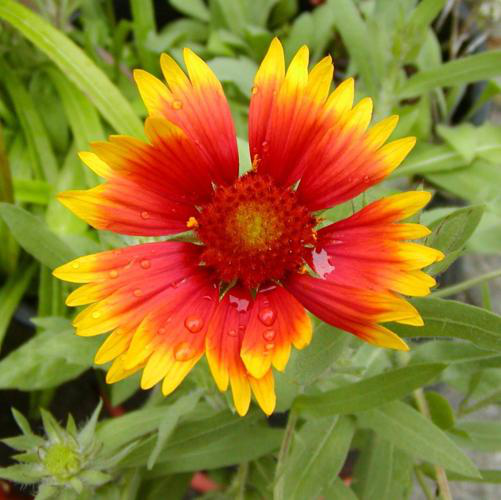

In [49]:
# Reading another image to plot
image_example_path2 = 'flowers/test/100/image_07899.jpg'
im2 = Image.open(image_example_path2)
im2

In [50]:
# transforming image
im_transformed = process_image(im2)

print('Image Trasformed')
print(im_transformed.shape)
print(im_transformed[0][0])

Image Trasformed
(3, 224, 224)
[ 0.48505865  0.60493193  0.79330422  0.9131775   0.74192996  0.63918144
  0.67343094  0.79330422  0.98167651  0.99880127  1.01592602  1.11867454
  1.06730028  0.98167651  0.75905471  0.50218341  0.27956161  0.03981505
 -0.09718298 -0.11430773 -0.31980478 -0.35405429 -0.49105232 -0.6451751
 -0.76504838 -0.81642264 -0.71367412 -0.40542855 -0.30268002 -0.09718298
  0.03981505  0.09118931  0.17681308  0.10831407 -0.09718298 -0.25130576
 -0.28555527 -0.31980478 -0.45680281 -0.91917116 -1.21029198 -1.07329395
 -0.8677969  -0.81642264 -0.74792362 -0.73079887 -0.73079887 -0.76504838
 -0.97054542 -1.3130405  -1.60416132 -1.26166624 -0.59380084 -0.23418101
 -0.23418101 -0.25130576 -0.31980478 -0.33692953 -0.31980478 -0.13143249
  0.15968833  0.39943488  0.17681308 -0.38830379 -1.05616919 -1.21029198
 -0.93629592 -0.57667609 -0.38830379 -0.18280675 -0.02868396  0.10831407
  0.22818734  0.31381111  0.31381111  0.2453121   0.10831407  0.03981505
 -0.04580872 -0.08005

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [51]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    # image = image.numpy().transpose((1, 2, 0)) #This part I changed
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

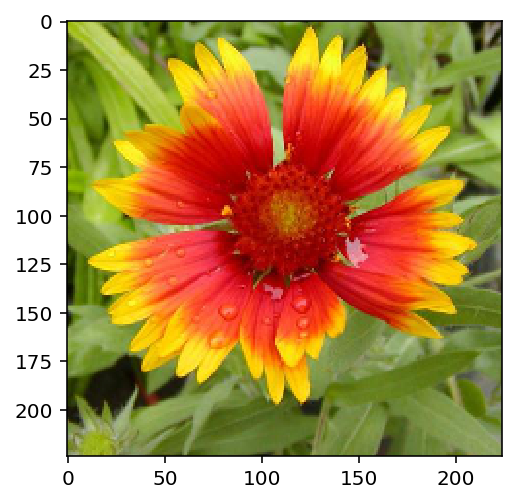

In [52]:
imshow(im_transformed)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

image Transformed


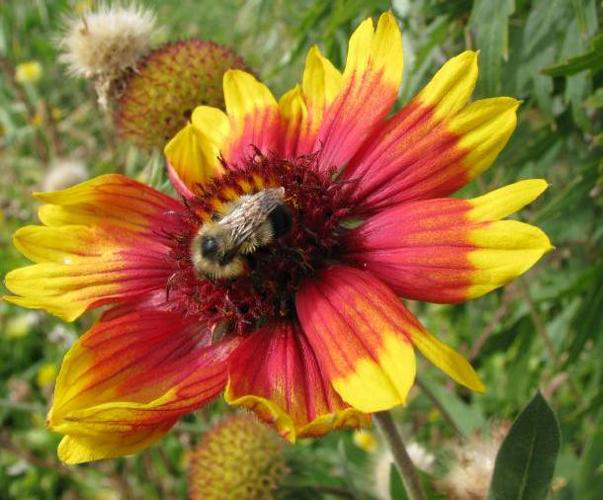

In [53]:
# Reading another image to plot
image_example_path3 = 'flowers/test/100/image_07896.jpg'
im3 = Image.open(image_example_path3)
im_t3 = process_image(im3)
print('image Transformed')
im3

In [54]:
# To tensor
torch.set_default_tensor_type('torch.DoubleTensor')
im_t3_tensor = torch.from_numpy(im_t3)
im_t3_tensor_reshape = im_t3_tensor.reshape([1, 3, 224, 224])

print(im_t3_tensor_reshape.shape)
print('Tensor transformation Done')

torch.Size([1, 3, 224, 224])
Tensor transformation Done


In [55]:
# Transforming model to work only with Double, not float
checkpoint_model = checkpoint_model.double()

In [56]:
# Results from image
im_output = checkpoint_model(im_t3_tensor_reshape)
im_output_prob = torch.exp(im_output)
im_output_prob

tensor([[ 4.5850e-29,  1.0820e-31,  9.1116e-04,  2.6241e-16,  3.8841e-23,
          9.8407e-25,  3.5886e-08,  2.6843e-16,  1.6972e-20,  1.7976e-14,
          1.9791e-24,  5.2958e-12,  1.7342e-14,  1.4857e-25,  2.9614e-20,
          6.3897e-32,  9.1035e-28,  9.0948e-24,  7.8612e-22,  8.8454e-27,
          1.8801e-29,  2.8937e-17,  3.9895e-16,  2.0847e-31,  2.1493e-19,
          2.5084e-24,  1.1260e-13,  2.5970e-26,  4.6718e-23,  2.1613e-25,
          4.5217e-13,  9.5741e-18,  4.0551e-22,  1.8721e-32,  2.2268e-14,
          2.2546e-38,  1.9975e-31,  1.9192e-21,  2.7173e-23,  4.4587e-17,
          4.6073e-20,  3.4579e-18,  7.2398e-26,  3.9039e-11,  9.3507e-19,
          1.6813e-18,  4.0939e-26,  2.5710e-02,  2.7552e-12,  1.6854e-08,
          1.7103e-16,  1.7962e-09,  3.8666e-11,  1.1516e-24,  2.4015e-15,
          1.6775e-29,  3.4703e-24,  1.4947e-14,  5.2464e-22,  4.7355e-22,
          1.3325e-22,  1.9752e-22,  3.1541e-04,  3.0773e-32,  8.5963e-16,
          4.6764e-25,  1.3173e-31,  6.

In [57]:
im_top_p, im_top_class = im_output_prob.topk(5, dim=1)
print(im_top_p)
print(im_top_class)

tensor([[ 9.7306e-01,  2.5710e-02,  9.1116e-04,  3.1541e-04,  3.5886e-08]])
tensor([[ 84,  47,   2,  62,   6]])


In [58]:
# TODO: Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model_d = model.double()
    
    im = Image.open(image_path)
    im_p = process_image(im)
    im_t = torch.from_numpy(im_p).reshape([1, 3, 224, 224])
    im_out = model_d(im_t)
    im_prb = torch.exp(im_out)
    im_top_p, im_top_class = im_prb.topk(topk, dim=1)

    return( (im_top_p.tolist()[0], im_top_class.tolist()[0]) )

print('Predict Created')    

Predict Created


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [69]:
# TODO: Display an image along with the top 5 classes
image_example_path_sanity = 'flowers/train/17/image_03838.jpg'
image_example_sanity = Image.open(image_example_path_sanity)
top_p, top_c = predict(image_example_path_sanity, checkpoint_model)

# model.to('cpu')
# top_p, top_c = predict(image_example_path_sanity, model)

print('Prediction Done')

Prediction Done


In [98]:
# Folder number to folder name
folder_number_to_name = {0:'1',1:'10',2:'100',3:'101',4:'102',5:'11',6:'12',7:'13',8:'14',9:'15',10:'16',11:'17',12:'18',13:'19',14:'2',15:'20',16:'21',17:'22',18:'23',19:'24',20:'25',21:'26',22:'27',23:'28',24:'29',25:'3',26:'30',27:'31',28:'32',29:'33',30:'34',31:'35',32:'36',33:'37',34:'38',35:'39',36:'4',37:'40',38:'41',39:'42',40:'43',41:'44',42:'45',43:'46',44:'47',45:'48',46:'49',47:'5',48:'50',49:'51',50:'52',51:'53',52:'54',53:'55',54:'56',55:'57',56:'58',57:'59',58:'6',59:'60',60:'61',61:'62',62:'63',63:'64',64:'65',65:'66',66:'67',67:'68',68:'69',69:'7',70:'70',71:'71',72:'72',73:'73',74:'74',75:'75',76:'76',77:'77',78:'78',79:'79',80:'8',81:'80',82:'81',83:'82',84:'83',85:'84',86:'85',87:'86',88:'87',89:'88',90:'89',91:'9',92:'90',93:'91',94:'92',95:'93',96:'94',97:'95',98:'96',99:'97',100:'98',101:'99'}
print('target transformation complete')
#folder_number_to_name

target transformation complete


In [102]:
# Transforming from class number to name
top_names = []
for c in top_c:
    top_names.append( cat_to_name[folder_number_to_name[c]] )

# top_names
# cat_to_name
print('name transformation done')

name transformation done


In [103]:
top_p, top_c

([0.9995377228751361,
  0.00035258997062204573,
  0.00010960841252903715,
  5.14131074600868e-08,
  8.14047260699988e-09],
 [11, 49, 84, 68, 77])

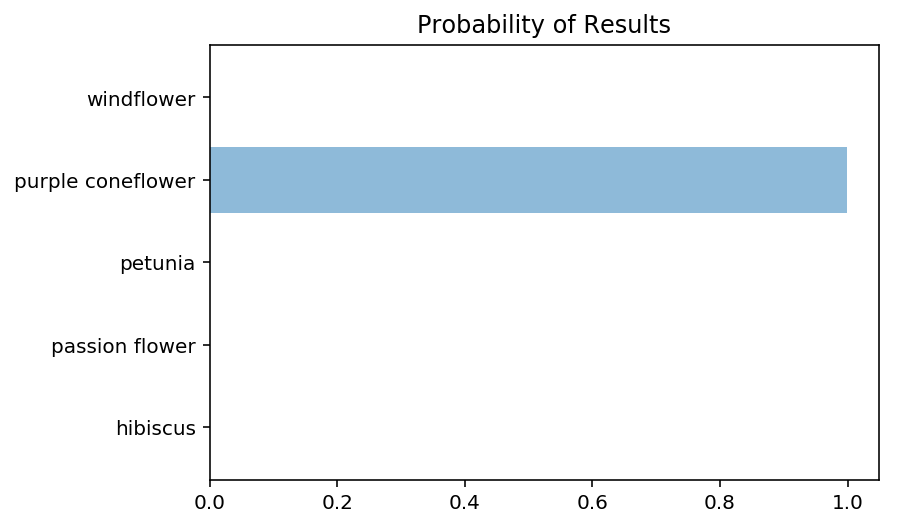

In [104]:
# Plotting results
plt.barh(top_names, top_p, alpha=0.5)
plt.title('Probability of Results')
plt.show()

In [105]:
# Rescuing The name from image path
m = re.search('flowers/[A-z]*/(.+?)/', image_example_path_sanity)
if m:
    im_category_number = m.group(1)
im_category_name = cat_to_name[im_category_number]

print('The species from the Flower')
print(im_category_name)
print(im_category_number)

The species from the Flower
purple coneflower
17


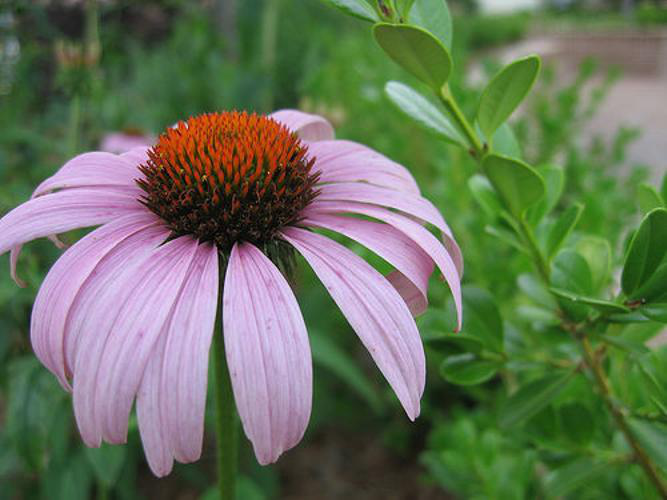

In [106]:
# Plotting Image
image_example_sanity

#FIRST PART COMPLETE